# PyTorch MNIST example

In [45]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Load the datasets
train_data = pd.read_csv("mnist_train.csv")
test_data = pd.read_csv("mnist_test.csv")

# Split data into features (X) and labels (y) for the training set
X_train_full = train_data.iloc[:, 1:]  # all columns except the first one
Y_train_full = train_data.iloc[:, 0]   # only the first column (labels)

# Split data into features (X) and labels (y) for the test set
X_test = test_data.iloc[:, 1:]  # all columns except the first one
Y_test = test_data.iloc[:, 0]   # only the first column (labels)

# Splitting the Training Data into training and validation sets using stratified sampling
X_train, X_val, Y_train, Y_val = train_test_split(X_train_full, Y_train_full, test_size=0.2, stratify=Y_train_full, random_state=42)

## Visualize the data

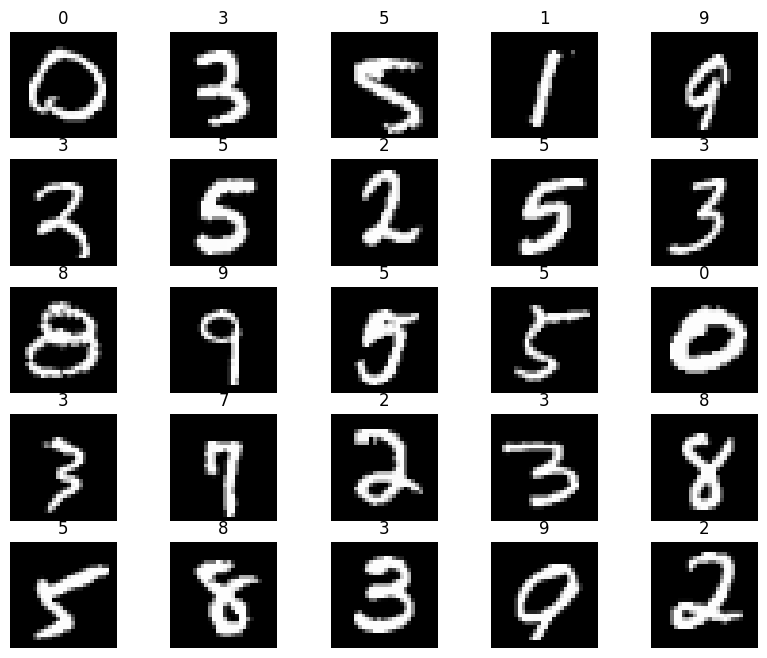

In [46]:
import matplotlib.pyplot as plt
import numpy as np

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(X_train))
    img = X_train.iloc[sample_idx].values.reshape(28, 28)
    label = Y_train.iloc[sample_idx]
    
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img, cmap="gray")

plt.show()

## Building `DataLoaders` classes to load data

In [47]:
# Creating PyTorch Datasets
train_dataset = TensorDataset(torch.tensor(X_train.values.reshape(-1, 1, 28, 28), dtype=torch.float32), torch.tensor(Y_train.values, dtype=torch.int64))
val_dataset = TensorDataset(torch.tensor(X_val.values.reshape(-1, 1, 28, 28), dtype=torch.float32), torch.tensor(Y_val.values, dtype=torch.int64))
test_dataset = TensorDataset(torch.tensor(X_test.values.reshape(-1, 1, 28, 28), dtype=torch.float32), torch.tensor(Y_test.values, dtype=torch.int64))
batch_size= 64
num_workers = 1

def create_loaders(batch_size):
    loaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers),
        'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    }
    return loaders

## Using the `dataloader`

torch.Size([64, 1, 28, 28])


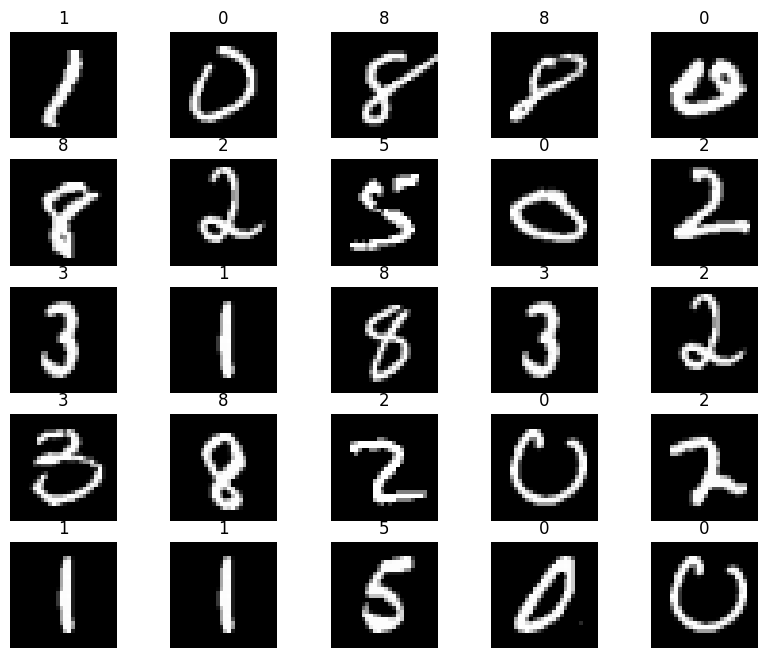

In [48]:
loaders = create_loaders(batch_size)

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

imgs, labels = next(iter(loaders['train']))
print(imgs.shape)  
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(imgs.shape[0], size=(1,)).item()
    img, label = imgs[sample_idx,:,:], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Model

In [49]:
import torch.nn as nn

class OneBlockCNN(nn.Module):
    def __init__(self, kernel_size=3, num_classes=10):
        super(OneBlockCNN, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=kernel_size, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.out = nn.Linear(32*14*14, num_classes)
        
    def forward(self, x):
        x = self.block1(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [50]:
class TwoBlockCNN(nn.Module):
    def __init__(self, kernel_size=3, num_classes=10):
        super(TwoBlockCNN, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=kernel_size, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=kernel_size, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.out = nn.Linear(32*8*8, num_classes)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [51]:
one_block_cnn = OneBlockCNN()
two_block_cnn = TwoBlockCNN()
print(one_block_cnn, two_block_cnn)

OneBlockCNN(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=6272, out_features=10, bias=True)
) TwoBlockCNN(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2048, out_features=10, bias=True)
)


## Loss function

In [52]:
loss_func = nn.CrossEntropyLoss()
print(loss_func)

CrossEntropyLoss()


In [53]:
from torch import optim

optimizer_one = optim.SGD(one_block_cnn.parameters(), lr=0.001, momentum=0.5)
optimizer_two = optim.SGD(two_block_cnn.parameters(), lr=0.001, momentum=0.9)

## Train the model

In [54]:
num_epochs = 10
def train_model(model, optimizer, num_epochs, loaders):
    model.train()
    train_accuracies = []
    val_accuracies = []
    early_stopping_patience = 3
    early_stopping_counter = 0
    best_val_loss = float('inf')

    total_step = len(loaders['train'])
    print(f"Total number of batches: {total_step}")

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch + 1}/{num_epochs}...")
        
        correct_train = 0
        total_train = 0
        # Training phase
        for i, (images, labels) in enumerate(loaders['train']):
            output = model(images)
            loss = loss_func(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted_train = torch.max(output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            # Print every 100 steps
            if (i+1) % 100 == 0:
                train_accuracy = 100 * correct_train / ((i+1) * images.size(0))
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Training Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), train_accuracy))
        
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        print(f"End of Epoch {epoch+1}, Training Accuracy: {train_accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(loaders['val']):
            output = model(images)
            loss = loss_func(output, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss /= len(loaders['val'])
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        print(f"End of Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping!")
            break
        
        model.train()  # Switch back to training mode for the next epoch

    return train_accuracies, val_accuracies

### In the following two cells, I've been using a grid search to search for the best parameters. Commented out due to the fact that this is a time consuming process

In [19]:
"""

from torch import optim

kernel_sizes = [3, 5]
batch_sizes = [64, 128, 256]
learning_rates = [0.001, 0.01]
optimizers_list = ['Adam', 'SGD']
momentums = [0.5, 0.9, 0.99]

best_val_accuracy = 0
best_params = {}

for kernel_size in kernel_sizes:
    for batch_size in batch_sizes:
        loaders = create_loaders(batch_size)
        for lr in learning_rates:
            for opt in optimizers_list:
                if opt == 'Adam':
                    optimizer = optim.Adam(one_block_cnn.parameters(), lr=lr)
                else:
                    for momentum in momentums:
                        optimizer = optim.SGD(one_block_cnn.parameters(), lr=lr, momentum=momentum)
                        train_accuracies, val_accuracies = train_model(one_block_cnn, optimizer, num_epochs, loaders)
                        if max(val_accuracies) > best_val_accuracy:
                            best_val_accuracy = max(val_accuracies)
                            best_params = {
                                'kernel_size': kernel_size,
                                'batch_size': batch_size,
                                'lr': lr,
                                'optimizer': opt,
                                'momentum': momentum
                            }

print("Best parameters:", best_params)

"""

Total number of batches: 750
Starting epoch 1/10...
Epoch [1/10], Step [100/750], Loss: 0.2787, Training Accuracy: 82.22%
Epoch [1/10], Step [200/750], Loss: 0.1103, Training Accuracy: 87.18%
Epoch [1/10], Step [300/750], Loss: 0.2235, Training Accuracy: 89.44%
Epoch [1/10], Step [400/750], Loss: 0.1240, Training Accuracy: 90.68%
Epoch [1/10], Step [500/750], Loss: 0.1262, Training Accuracy: 91.52%
Epoch [1/10], Step [600/750], Loss: 0.0917, Training Accuracy: 92.20%
Epoch [1/10], Step [700/750], Loss: 0.0691, Training Accuracy: 92.66%
End of Epoch 1, Training Accuracy: 92.87%
End of Epoch 1, Validation Loss: 0.1494, Validation Accuracy: 95.58%
Starting epoch 2/10...
Epoch [2/10], Step [100/750], Loss: 0.1764, Training Accuracy: 96.86%
Epoch [2/10], Step [200/750], Loss: 0.0803, Training Accuracy: 96.65%
Epoch [2/10], Step [300/750], Loss: 0.1773, Training Accuracy: 96.60%
Epoch [2/10], Step [400/750], Loss: 0.0630, Training Accuracy: 96.71%
Epoch [2/10], Step [500/750], Loss: 0.0182, 

Epoch [6/10], Step [100/750], Loss: 0.0110, Training Accuracy: 99.44%
Epoch [6/10], Step [200/750], Loss: 0.0074, Training Accuracy: 99.40%
Epoch [6/10], Step [300/750], Loss: 0.0022, Training Accuracy: 99.32%
Epoch [6/10], Step [400/750], Loss: 0.0051, Training Accuracy: 99.34%
Epoch [6/10], Step [500/750], Loss: 0.0990, Training Accuracy: 99.35%
Epoch [6/10], Step [600/750], Loss: 0.0611, Training Accuracy: 99.27%
Epoch [6/10], Step [700/750], Loss: 0.0015, Training Accuracy: 99.21%
End of Epoch 6, Training Accuracy: 99.21%
End of Epoch 6, Validation Loss: 0.1372, Validation Accuracy: 96.93%
Early stopping!
Total number of batches: 750
Starting epoch 1/10...
Epoch [1/10], Step [100/750], Loss: 0.9489, Training Accuracy: 95.50%
Epoch [1/10], Step [200/750], Loss: 0.4374, Training Accuracy: 89.30%
Epoch [1/10], Step [300/750], Loss: 0.3754, Training Accuracy: 87.32%
Epoch [1/10], Step [400/750], Loss: 0.2785, Training Accuracy: 87.17%
Epoch [1/10], Step [500/750], Loss: 0.5273, Trainin

Epoch [8/10], Step [100/750], Loss: 0.2990, Training Accuracy: 93.55%
Epoch [8/10], Step [200/750], Loss: 0.2647, Training Accuracy: 93.36%
Epoch [8/10], Step [300/750], Loss: 0.2098, Training Accuracy: 93.51%
Epoch [8/10], Step [400/750], Loss: 0.1054, Training Accuracy: 93.36%
Epoch [8/10], Step [500/750], Loss: 0.0781, Training Accuracy: 93.19%
Epoch [8/10], Step [600/750], Loss: 0.3360, Training Accuracy: 93.18%
Epoch [8/10], Step [700/750], Loss: 0.1402, Training Accuracy: 93.22%
End of Epoch 8, Training Accuracy: 93.22%
End of Epoch 8, Validation Loss: 0.2466, Validation Accuracy: 92.53%
Starting epoch 9/10...
Epoch [9/10], Step [100/750], Loss: 0.2286, Training Accuracy: 93.64%
Epoch [9/10], Step [200/750], Loss: 0.2276, Training Accuracy: 93.50%
Epoch [9/10], Step [300/750], Loss: 0.1905, Training Accuracy: 93.18%
Epoch [9/10], Step [400/750], Loss: 0.3539, Training Accuracy: 93.13%
Epoch [9/10], Step [500/750], Loss: 0.2486, Training Accuracy: 93.29%
Epoch [9/10], Step [600/75

Epoch [4/10], Step [100/750], Loss: 0.3328, Training Accuracy: 86.31%
Epoch [4/10], Step [200/750], Loss: 0.5209, Training Accuracy: 86.77%
Epoch [4/10], Step [300/750], Loss: 0.4205, Training Accuracy: 86.82%
Epoch [4/10], Step [400/750], Loss: 0.3189, Training Accuracy: 86.79%
Epoch [4/10], Step [500/750], Loss: 0.3559, Training Accuracy: 86.94%
Epoch [4/10], Step [600/750], Loss: 0.5058, Training Accuracy: 87.17%
Epoch [4/10], Step [700/750], Loss: 0.3379, Training Accuracy: 87.15%
End of Epoch 4, Training Accuracy: 87.18%
End of Epoch 4, Validation Loss: 0.4012, Validation Accuracy: 87.75%
Starting epoch 5/10...
Epoch [5/10], Step [100/750], Loss: 0.3735, Training Accuracy: 86.31%
Epoch [5/10], Step [200/750], Loss: 0.4519, Training Accuracy: 86.77%
Epoch [5/10], Step [300/750], Loss: 0.3954, Training Accuracy: 87.32%
Epoch [5/10], Step [400/750], Loss: 0.5775, Training Accuracy: 87.47%
Epoch [5/10], Step [500/750], Loss: 0.5049, Training Accuracy: 87.39%
Epoch [5/10], Step [600/75

End of Epoch 3, Validation Loss: 0.3768, Validation Accuracy: 88.77%
Starting epoch 4/10...
Epoch [4/10], Step [100/375], Loss: 0.3595, Training Accuracy: 88.84%
Epoch [4/10], Step [200/375], Loss: 0.3130, Training Accuracy: 88.94%
Epoch [4/10], Step [300/375], Loss: 0.4434, Training Accuracy: 89.01%
End of Epoch 4, Training Accuracy: 89.04%
End of Epoch 4, Validation Loss: 0.3771, Validation Accuracy: 88.72%
Starting epoch 5/10...
Epoch [5/10], Step [100/375], Loss: 0.3458, Training Accuracy: 89.33%
Epoch [5/10], Step [200/375], Loss: 0.4107, Training Accuracy: 89.12%
Epoch [5/10], Step [300/375], Loss: 0.4275, Training Accuracy: 88.93%
End of Epoch 5, Training Accuracy: 89.02%
End of Epoch 5, Validation Loss: 0.3767, Validation Accuracy: 88.70%
Starting epoch 6/10...
Epoch [6/10], Step [100/375], Loss: 0.5055, Training Accuracy: 89.22%
Epoch [6/10], Step [200/375], Loss: 0.2297, Training Accuracy: 89.04%
Epoch [6/10], Step [300/375], Loss: 0.2003, Training Accuracy: 89.01%
End of Epo

Epoch [2/10], Step [300/375], Loss: 0.2229, Training Accuracy: 89.20%
End of Epoch 2, Training Accuracy: 89.07%
End of Epoch 2, Validation Loss: 0.3763, Validation Accuracy: 88.71%
Starting epoch 3/10...
Epoch [3/10], Step [100/375], Loss: 0.5060, Training Accuracy: 89.09%
Epoch [3/10], Step [200/375], Loss: 0.3510, Training Accuracy: 89.16%
Epoch [3/10], Step [300/375], Loss: 0.3734, Training Accuracy: 89.11%
End of Epoch 3, Training Accuracy: 89.06%
End of Epoch 3, Validation Loss: 0.3757, Validation Accuracy: 88.86%
Starting epoch 4/10...
Epoch [4/10], Step [100/375], Loss: 0.3340, Training Accuracy: 88.99%
Epoch [4/10], Step [200/375], Loss: 0.4925, Training Accuracy: 88.89%
Epoch [4/10], Step [300/375], Loss: 0.3618, Training Accuracy: 89.00%
End of Epoch 4, Training Accuracy: 88.97%
End of Epoch 4, Validation Loss: 0.3773, Validation Accuracy: 88.70%
Starting epoch 5/10...
Epoch [5/10], Step [100/375], Loss: 0.4399, Training Accuracy: 88.92%
Epoch [5/10], Step [200/375], Loss: 0.

End of Epoch 2, Training Accuracy: 89.12%
End of Epoch 2, Validation Loss: 0.3755, Validation Accuracy: 88.67%
Starting epoch 3/10...
Epoch [3/10], Step [100/188], Loss: 0.3374, Training Accuracy: 89.03%
End of Epoch 3, Training Accuracy: 89.06%
End of Epoch 3, Validation Loss: 0.3756, Validation Accuracy: 88.81%
Starting epoch 4/10...
Epoch [4/10], Step [100/188], Loss: 0.3478, Training Accuracy: 89.17%
End of Epoch 4, Training Accuracy: 89.11%
End of Epoch 4, Validation Loss: 0.3749, Validation Accuracy: 88.77%
Early stopping!
Total number of batches: 188
Starting epoch 1/10...
Epoch [1/10], Step [100/188], Loss: 0.3290, Training Accuracy: 89.08%
End of Epoch 1, Training Accuracy: 89.10%
End of Epoch 1, Validation Loss: 0.3746, Validation Accuracy: 88.88%
Starting epoch 2/10...
Epoch [2/10], Step [100/188], Loss: 0.3106, Training Accuracy: 89.16%
End of Epoch 2, Training Accuracy: 89.12%
End of Epoch 2, Validation Loss: 0.3739, Validation Accuracy: 88.78%
Starting epoch 3/10...
Epoch

End of Epoch 4, Validation Loss: 0.3733, Validation Accuracy: 88.81%
Starting epoch 5/10...
Epoch [5/10], Step [100/750], Loss: 0.2210, Training Accuracy: 89.11%
Epoch [5/10], Step [200/750], Loss: 0.3636, Training Accuracy: 89.16%
Epoch [5/10], Step [300/750], Loss: 0.3189, Training Accuracy: 89.21%
Epoch [5/10], Step [400/750], Loss: 0.3346, Training Accuracy: 89.09%
Epoch [5/10], Step [500/750], Loss: 0.2786, Training Accuracy: 89.27%
Epoch [5/10], Step [600/750], Loss: 0.2811, Training Accuracy: 89.20%
Epoch [5/10], Step [700/750], Loss: 0.4976, Training Accuracy: 89.16%
End of Epoch 5, Training Accuracy: 89.19%
End of Epoch 5, Validation Loss: 0.3733, Validation Accuracy: 88.81%
Starting epoch 6/10...
Epoch [6/10], Step [100/750], Loss: 0.2830, Training Accuracy: 89.03%
Epoch [6/10], Step [200/750], Loss: 0.4833, Training Accuracy: 89.27%
Epoch [6/10], Step [300/750], Loss: 0.1606, Training Accuracy: 89.10%
Epoch [6/10], Step [400/750], Loss: 0.2914, Training Accuracy: 89.26%
Epoc

End of Epoch 3, Validation Loss: 0.3797, Validation Accuracy: 88.22%
Starting epoch 4/10...
Epoch [4/10], Step [100/750], Loss: 0.2098, Training Accuracy: 89.11%
Epoch [4/10], Step [200/750], Loss: 0.5451, Training Accuracy: 89.12%
Epoch [4/10], Step [300/750], Loss: 0.6326, Training Accuracy: 89.22%
Epoch [4/10], Step [400/750], Loss: 0.2471, Training Accuracy: 89.25%
Epoch [4/10], Step [500/750], Loss: 0.2720, Training Accuracy: 89.13%
Epoch [4/10], Step [600/750], Loss: 0.2614, Training Accuracy: 89.20%
Epoch [4/10], Step [700/750], Loss: 0.2138, Training Accuracy: 89.10%
End of Epoch 4, Training Accuracy: 89.07%
End of Epoch 4, Validation Loss: 0.3809, Validation Accuracy: 88.53%
Early stopping!
Total number of batches: 750
Starting epoch 1/10...
Epoch [1/10], Step [100/750], Loss: 0.3026, Training Accuracy: 89.45%
Epoch [1/10], Step [200/750], Loss: 0.6125, Training Accuracy: 89.27%
Epoch [1/10], Step [300/750], Loss: 0.2946, Training Accuracy: 89.03%
Epoch [1/10], Step [400/750],

End of Epoch 2, Training Accuracy: 87.86%
End of Epoch 2, Validation Loss: 0.4602, Validation Accuracy: 86.23%
Starting epoch 3/10...
Epoch [3/10], Step [100/750], Loss: 0.2956, Training Accuracy: 87.53%
Epoch [3/10], Step [200/750], Loss: 0.3076, Training Accuracy: 87.74%
Epoch [3/10], Step [300/750], Loss: 0.5162, Training Accuracy: 87.26%
Epoch [3/10], Step [400/750], Loss: 0.5110, Training Accuracy: 87.39%
Epoch [3/10], Step [500/750], Loss: 0.2587, Training Accuracy: 87.47%
Epoch [3/10], Step [600/750], Loss: 0.4954, Training Accuracy: 87.48%
Epoch [3/10], Step [700/750], Loss: 0.3442, Training Accuracy: 87.47%
End of Epoch 3, Training Accuracy: 87.51%
End of Epoch 3, Validation Loss: 0.3995, Validation Accuracy: 87.78%
Starting epoch 4/10...
Epoch [4/10], Step [100/750], Loss: 0.5925, Training Accuracy: 87.75%
Epoch [4/10], Step [200/750], Loss: 0.3013, Training Accuracy: 88.04%
Epoch [4/10], Step [300/750], Loss: 0.5479, Training Accuracy: 87.93%
Epoch [4/10], Step [400/750], Lo

End of Epoch 10, Training Accuracy: 89.08%
End of Epoch 10, Validation Loss: 0.3742, Validation Accuracy: 88.60%
Total number of batches: 375
Starting epoch 1/10...
Epoch [1/10], Step [100/375], Loss: 0.3116, Training Accuracy: 88.96%
Epoch [1/10], Step [200/375], Loss: 0.2490, Training Accuracy: 89.11%
Epoch [1/10], Step [300/375], Loss: 0.4081, Training Accuracy: 88.98%
End of Epoch 1, Training Accuracy: 89.12%
End of Epoch 1, Validation Loss: 0.3752, Validation Accuracy: 88.55%
Starting epoch 2/10...
Epoch [2/10], Step [100/375], Loss: 0.3304, Training Accuracy: 88.81%
Epoch [2/10], Step [200/375], Loss: 0.3048, Training Accuracy: 88.85%
Epoch [2/10], Step [300/375], Loss: 0.2493, Training Accuracy: 89.01%
End of Epoch 2, Training Accuracy: 89.06%
End of Epoch 2, Validation Loss: 0.3745, Validation Accuracy: 88.56%
Starting epoch 3/10...
Epoch [3/10], Step [100/375], Loss: 0.3184, Training Accuracy: 88.98%
Epoch [3/10], Step [200/375], Loss: 0.4522, Training Accuracy: 88.89%
Epoch [

Epoch [5/10], Step [100/375], Loss: 0.2510, Training Accuracy: 88.57%
Epoch [5/10], Step [200/375], Loss: 0.3667, Training Accuracy: 88.53%
Epoch [5/10], Step [300/375], Loss: 0.4641, Training Accuracy: 88.41%
End of Epoch 5, Training Accuracy: 88.39%
End of Epoch 5, Validation Loss: 0.3945, Validation Accuracy: 87.85%
Starting epoch 6/10...
Epoch [6/10], Step [100/375], Loss: 0.3585, Training Accuracy: 88.62%
Epoch [6/10], Step [200/375], Loss: 0.3358, Training Accuracy: 88.86%
Epoch [6/10], Step [300/375], Loss: 0.5030, Training Accuracy: 88.69%
End of Epoch 6, Training Accuracy: 88.58%
End of Epoch 6, Validation Loss: 0.3912, Validation Accuracy: 87.69%
Starting epoch 7/10...
Epoch [7/10], Step [100/375], Loss: 0.2733, Training Accuracy: 88.45%
Epoch [7/10], Step [200/375], Loss: 0.4338, Training Accuracy: 88.04%
Epoch [7/10], Step [300/375], Loss: 0.4033, Training Accuracy: 88.26%
End of Epoch 7, Training Accuracy: 88.31%
End of Epoch 7, Validation Loss: 0.3997, Validation Accuracy

End of Epoch 6, Training Accuracy: 89.09%
End of Epoch 6, Validation Loss: 0.3736, Validation Accuracy: 88.85%
Early stopping!
Total number of batches: 188
Starting epoch 1/10...
Epoch [1/10], Step [100/188], Loss: 0.3689, Training Accuracy: 88.96%
End of Epoch 1, Training Accuracy: 89.00%
End of Epoch 1, Validation Loss: 0.3858, Validation Accuracy: 88.33%
Starting epoch 2/10...
Epoch [2/10], Step [100/188], Loss: 0.3721, Training Accuracy: 88.79%
End of Epoch 2, Training Accuracy: 88.91%
End of Epoch 2, Validation Loss: 0.3815, Validation Accuracy: 88.71%
Starting epoch 3/10...
Epoch [3/10], Step [100/188], Loss: 0.3742, Training Accuracy: 89.13%
End of Epoch 3, Training Accuracy: 88.99%
End of Epoch 3, Validation Loss: 0.3925, Validation Accuracy: 88.33%
Starting epoch 4/10...
Epoch [4/10], Step [100/188], Loss: 0.3293, Training Accuracy: 89.14%
End of Epoch 4, Training Accuracy: 89.03%
End of Epoch 4, Validation Loss: 0.3813, Validation Accuracy: 88.48%
Starting epoch 5/10...
Epoch

In [20]:
"""

from torch import optim

kernel_sizes = [3, 5]
batch_sizes = [64, 128, 256]
learning_rates = [0.001, 0.01]
optimizers_list = ['Adam', 'SGD']
momentums = [0.5, 0.9, 0.99]

best_val_accuracy = 0
best_params = {}

for kernel_size in kernel_sizes:
    for batch_size in batch_sizes:
        loaders = create_loaders(batch_size)
        for lr in learning_rates:
            for opt in optimizers_list:
                if opt == 'Adam':
                    optimizer = optim.Adam(two_block_cnn.parameters(), lr=lr)
                else:
                    for momentum in momentums:
                        optimizer = optim.SGD(two_block_cnn.parameters(), lr=lr, momentum=momentum)
                        train_accuracies, val_accuracies = train_model(two_block_cnn, optimizer, num_epochs, loaders)
                        if max(val_accuracies) > best_val_accuracy:
                            best_val_accuracy = max(val_accuracies)
                            best_params = {
                                'kernel_size': kernel_size,
                                'batch_size': batch_size,
                                'lr': lr,
                                'optimizer': opt,
                                'momentum': momentum
                            }

print("Best parameters:", best_params)
"""

Total number of batches: 750
Starting epoch 1/10...
Epoch [1/10], Step [100/750], Loss: 0.1374, Training Accuracy: 77.81%
Epoch [1/10], Step [200/750], Loss: 0.1441, Training Accuracy: 85.72%
Epoch [1/10], Step [300/750], Loss: 0.0670, Training Accuracy: 88.74%
Epoch [1/10], Step [400/750], Loss: 0.2049, Training Accuracy: 90.49%
Epoch [1/10], Step [500/750], Loss: 0.3184, Training Accuracy: 91.67%
Epoch [1/10], Step [600/750], Loss: 0.0882, Training Accuracy: 92.40%
Epoch [1/10], Step [700/750], Loss: 0.0548, Training Accuracy: 93.03%
End of Epoch 1, Training Accuracy: 93.32%
End of Epoch 1, Validation Loss: 0.0953, Validation Accuracy: 96.99%
Starting epoch 2/10...
Epoch [2/10], Step [100/750], Loss: 0.1678, Training Accuracy: 97.06%
Epoch [2/10], Step [200/750], Loss: 0.0839, Training Accuracy: 97.30%
Epoch [2/10], Step [300/750], Loss: 0.1203, Training Accuracy: 97.32%
Epoch [2/10], Step [400/750], Loss: 0.0821, Training Accuracy: 97.35%
Epoch [2/10], Step [500/750], Loss: 0.0772, 

Epoch [4/10], Step [100/750], Loss: 0.0358, Training Accuracy: 98.97%
Epoch [4/10], Step [200/750], Loss: 0.0533, Training Accuracy: 98.91%
Epoch [4/10], Step [300/750], Loss: 0.0020, Training Accuracy: 98.84%
Epoch [4/10], Step [400/750], Loss: 0.0101, Training Accuracy: 98.84%
Epoch [4/10], Step [500/750], Loss: 0.0061, Training Accuracy: 98.84%
Epoch [4/10], Step [600/750], Loss: 0.0073, Training Accuracy: 98.83%
Epoch [4/10], Step [700/750], Loss: 0.0278, Training Accuracy: 98.89%
End of Epoch 4, Training Accuracy: 98.89%
End of Epoch 4, Validation Loss: 0.0584, Validation Accuracy: 98.46%
Starting epoch 5/10...
Epoch [5/10], Step [100/750], Loss: 0.0175, Training Accuracy: 99.20%
Epoch [5/10], Step [200/750], Loss: 0.0001, Training Accuracy: 99.26%
Epoch [5/10], Step [300/750], Loss: 0.1140, Training Accuracy: 99.19%
Epoch [5/10], Step [400/750], Loss: 0.0228, Training Accuracy: 99.19%
Epoch [5/10], Step [500/750], Loss: 0.0362, Training Accuracy: 99.17%
Epoch [5/10], Step [600/75

Epoch [10/10], Step [200/750], Loss: 0.1275, Training Accuracy: 96.02%
Epoch [10/10], Step [300/750], Loss: 0.0768, Training Accuracy: 95.81%
Epoch [10/10], Step [400/750], Loss: 0.2189, Training Accuracy: 95.87%
Epoch [10/10], Step [500/750], Loss: 0.0796, Training Accuracy: 95.81%
Epoch [10/10], Step [600/750], Loss: 0.1153, Training Accuracy: 95.78%
Epoch [10/10], Step [700/750], Loss: 0.0334, Training Accuracy: 95.84%
End of Epoch 10, Training Accuracy: 95.87%
End of Epoch 10, Validation Loss: 0.1364, Validation Accuracy: 95.92%
Total number of batches: 750
Starting epoch 1/10...
Epoch [1/10], Step [100/750], Loss: 0.0428, Training Accuracy: 97.19%
Epoch [1/10], Step [200/750], Loss: 0.1156, Training Accuracy: 97.47%
Epoch [1/10], Step [300/750], Loss: 0.0864, Training Accuracy: 97.58%
Epoch [1/10], Step [400/750], Loss: 0.1034, Training Accuracy: 97.55%
Epoch [1/10], Step [500/750], Loss: 0.0404, Training Accuracy: 97.60%
Epoch [1/10], Step [600/750], Loss: 0.0104, Training Accura

Epoch [2/10], Step [200/750], Loss: 0.5193, Training Accuracy: 90.48%
Epoch [2/10], Step [300/750], Loss: 0.4054, Training Accuracy: 90.25%
Epoch [2/10], Step [400/750], Loss: 0.2524, Training Accuracy: 90.27%
Epoch [2/10], Step [500/750], Loss: 0.2451, Training Accuracy: 90.30%
Epoch [2/10], Step [600/750], Loss: 0.2349, Training Accuracy: 90.27%
Epoch [2/10], Step [700/750], Loss: 0.1443, Training Accuracy: 90.19%
End of Epoch 2, Training Accuracy: 90.25%
End of Epoch 2, Validation Loss: 0.2888, Validation Accuracy: 90.07%
Starting epoch 3/10...
Epoch [3/10], Step [100/750], Loss: 0.2352, Training Accuracy: 90.67%
Epoch [3/10], Step [200/750], Loss: 0.1974, Training Accuracy: 90.66%
Epoch [3/10], Step [300/750], Loss: 0.2520, Training Accuracy: 90.74%
Epoch [3/10], Step [400/750], Loss: 0.4340, Training Accuracy: 90.89%
Epoch [3/10], Step [500/750], Loss: 0.3100, Training Accuracy: 91.08%
Epoch [3/10], Step [600/750], Loss: 0.4145, Training Accuracy: 91.17%
Epoch [3/10], Step [700/75

Epoch [4/10], Step [100/375], Loss: 0.2842, Training Accuracy: 93.05%
Epoch [4/10], Step [200/375], Loss: 0.2359, Training Accuracy: 92.92%
Epoch [4/10], Step [300/375], Loss: 0.2060, Training Accuracy: 93.02%
End of Epoch 4, Training Accuracy: 93.15%
End of Epoch 4, Validation Loss: 0.2418, Validation Accuracy: 91.86%
Starting epoch 5/10...
Epoch [5/10], Step [100/375], Loss: 0.2555, Training Accuracy: 93.20%
Epoch [5/10], Step [200/375], Loss: 0.1339, Training Accuracy: 93.25%
Epoch [5/10], Step [300/375], Loss: 0.2681, Training Accuracy: 93.21%
End of Epoch 5, Training Accuracy: 93.20%
End of Epoch 5, Validation Loss: 0.2411, Validation Accuracy: 91.91%
Starting epoch 6/10...
Epoch [6/10], Step [100/375], Loss: 0.0994, Training Accuracy: 93.24%
Epoch [6/10], Step [200/375], Loss: 0.2420, Training Accuracy: 93.14%
Epoch [6/10], Step [300/375], Loss: 0.2278, Training Accuracy: 93.20%
End of Epoch 6, Training Accuracy: 93.21%
End of Epoch 6, Validation Loss: 0.2403, Validation Accuracy

End of Epoch 5, Training Accuracy: 93.71%
End of Epoch 5, Validation Loss: 0.2412, Validation Accuracy: 92.05%
Starting epoch 6/10...
Epoch [6/10], Step [100/375], Loss: 0.1500, Training Accuracy: 93.73%
Epoch [6/10], Step [200/375], Loss: 0.2673, Training Accuracy: 93.68%
Epoch [6/10], Step [300/375], Loss: 0.3253, Training Accuracy: 93.77%
End of Epoch 6, Training Accuracy: 93.73%
End of Epoch 6, Validation Loss: 0.2362, Validation Accuracy: 92.03%
Starting epoch 7/10...
Epoch [7/10], Step [100/375], Loss: 0.2539, Training Accuracy: 93.86%
Epoch [7/10], Step [200/375], Loss: 0.1967, Training Accuracy: 93.65%
Epoch [7/10], Step [300/375], Loss: 0.3004, Training Accuracy: 93.74%
End of Epoch 7, Training Accuracy: 93.73%
End of Epoch 7, Validation Loss: 0.2361, Validation Accuracy: 92.08%
Starting epoch 8/10...
Epoch [8/10], Step [100/375], Loss: 0.2335, Training Accuracy: 93.65%
Epoch [8/10], Step [200/375], Loss: 0.2050, Training Accuracy: 93.71%
Epoch [8/10], Step [300/375], Loss: 0.

End of Epoch 4, Validation Loss: 0.2392, Validation Accuracy: 92.05%
Early stopping!
Total number of batches: 188
Starting epoch 1/10...
Epoch [1/10], Step [100/188], Loss: 0.1808, Training Accuracy: 94.14%
End of Epoch 1, Training Accuracy: 94.16%
End of Epoch 1, Validation Loss: 0.2371, Validation Accuracy: 92.08%
Starting epoch 2/10...
Epoch [2/10], Step [100/188], Loss: 0.1620, Training Accuracy: 94.16%
End of Epoch 2, Training Accuracy: 94.14%
End of Epoch 2, Validation Loss: 0.2378, Validation Accuracy: 92.04%
Starting epoch 3/10...
Epoch [3/10], Step [100/188], Loss: 0.1611, Training Accuracy: 94.05%
End of Epoch 3, Training Accuracy: 94.13%
End of Epoch 3, Validation Loss: 0.2374, Validation Accuracy: 92.08%
Starting epoch 4/10...
Epoch [4/10], Step [100/188], Loss: 0.1899, Training Accuracy: 94.29%
End of Epoch 4, Training Accuracy: 94.14%
End of Epoch 4, Validation Loss: 0.2375, Validation Accuracy: 92.07%
Early stopping!
Total number of batches: 188
Starting epoch 1/10...
Ep

Epoch [9/10], Step [500/750], Loss: 0.1132, Training Accuracy: 94.27%
Epoch [9/10], Step [600/750], Loss: 0.1053, Training Accuracy: 94.32%
Epoch [9/10], Step [700/750], Loss: 0.0869, Training Accuracy: 94.27%
End of Epoch 9, Training Accuracy: 94.26%
End of Epoch 9, Validation Loss: 0.2406, Validation Accuracy: 92.12%
Starting epoch 10/10...
Epoch [10/10], Step [100/750], Loss: 0.1822, Training Accuracy: 93.98%
Epoch [10/10], Step [200/750], Loss: 0.2088, Training Accuracy: 94.19%
Epoch [10/10], Step [300/750], Loss: 0.1161, Training Accuracy: 94.20%
Epoch [10/10], Step [400/750], Loss: 0.2086, Training Accuracy: 94.15%
Epoch [10/10], Step [500/750], Loss: 0.1545, Training Accuracy: 94.17%
Epoch [10/10], Step [600/750], Loss: 0.0531, Training Accuracy: 94.25%
Epoch [10/10], Step [700/750], Loss: 0.0910, Training Accuracy: 94.23%
End of Epoch 10, Training Accuracy: 94.27%
End of Epoch 10, Validation Loss: 0.2405, Validation Accuracy: 92.11%
Total number of batches: 750
Starting epoch 1

Epoch [5/10], Step [500/750], Loss: 0.1596, Training Accuracy: 94.19%
Epoch [5/10], Step [600/750], Loss: 0.1869, Training Accuracy: 94.23%
Epoch [5/10], Step [700/750], Loss: 0.1830, Training Accuracy: 94.19%
End of Epoch 5, Training Accuracy: 94.14%
End of Epoch 5, Validation Loss: 0.2386, Validation Accuracy: 92.03%
Starting epoch 6/10...
Epoch [6/10], Step [100/750], Loss: 0.1510, Training Accuracy: 93.73%
Epoch [6/10], Step [200/750], Loss: 0.1870, Training Accuracy: 94.18%
Epoch [6/10], Step [300/750], Loss: 0.1798, Training Accuracy: 94.30%
Epoch [6/10], Step [400/750], Loss: 0.1120, Training Accuracy: 94.25%
Epoch [6/10], Step [500/750], Loss: 0.0878, Training Accuracy: 94.24%
Epoch [6/10], Step [600/750], Loss: 0.0459, Training Accuracy: 94.22%
Epoch [6/10], Step [700/750], Loss: 0.1957, Training Accuracy: 94.19%
End of Epoch 6, Training Accuracy: 94.14%
End of Epoch 6, Validation Loss: 0.2467, Validation Accuracy: 92.00%
Starting epoch 7/10...
Epoch [7/10], Step [100/750], Lo

Epoch [2/10], Step [500/750], Loss: 0.1984, Training Accuracy: 94.26%
Epoch [2/10], Step [600/750], Loss: 0.2003, Training Accuracy: 94.28%
Epoch [2/10], Step [700/750], Loss: 0.1789, Training Accuracy: 94.26%
End of Epoch 2, Training Accuracy: 94.22%
End of Epoch 2, Validation Loss: 0.2438, Validation Accuracy: 91.96%
Starting epoch 3/10...
Epoch [3/10], Step [100/750], Loss: 0.1895, Training Accuracy: 94.14%
Epoch [3/10], Step [200/750], Loss: 0.2089, Training Accuracy: 94.10%
Epoch [3/10], Step [300/750], Loss: 0.0986, Training Accuracy: 94.25%
Epoch [3/10], Step [400/750], Loss: 0.2191, Training Accuracy: 94.20%
Epoch [3/10], Step [500/750], Loss: 0.2598, Training Accuracy: 94.21%
Epoch [3/10], Step [600/750], Loss: 0.3777, Training Accuracy: 94.22%
Epoch [3/10], Step [700/750], Loss: 0.1194, Training Accuracy: 94.24%
End of Epoch 3, Training Accuracy: 94.25%
End of Epoch 3, Validation Loss: 0.2417, Validation Accuracy: 92.02%
Starting epoch 4/10...
Epoch [4/10], Step [100/750], Lo

Epoch [2/10], Step [100/375], Loss: 0.1252, Training Accuracy: 93.23%
Epoch [2/10], Step [200/375], Loss: 0.1887, Training Accuracy: 93.54%
Epoch [2/10], Step [300/375], Loss: 0.1982, Training Accuracy: 93.58%
End of Epoch 2, Training Accuracy: 93.69%
End of Epoch 2, Validation Loss: 0.2520, Validation Accuracy: 91.66%
Starting epoch 3/10...
Epoch [3/10], Step [100/375], Loss: 0.2016, Training Accuracy: 93.73%
Epoch [3/10], Step [200/375], Loss: 0.1631, Training Accuracy: 93.76%
Epoch [3/10], Step [300/375], Loss: 0.1940, Training Accuracy: 93.72%
End of Epoch 3, Training Accuracy: 93.76%
End of Epoch 3, Validation Loss: 0.2493, Validation Accuracy: 91.72%
Starting epoch 4/10...
Epoch [4/10], Step [100/375], Loss: 0.1226, Training Accuracy: 93.80%
Epoch [4/10], Step [200/375], Loss: 0.1884, Training Accuracy: 93.79%
Epoch [4/10], Step [300/375], Loss: 0.3110, Training Accuracy: 93.83%
End of Epoch 4, Training Accuracy: 93.84%
End of Epoch 4, Validation Loss: 0.2478, Validation Accuracy

End of Epoch 2, Training Accuracy: 94.55%
End of Epoch 2, Validation Loss: 0.2385, Validation Accuracy: 92.02%
Starting epoch 3/10...
Epoch [3/10], Step [100/375], Loss: 0.1354, Training Accuracy: 94.78%
Epoch [3/10], Step [200/375], Loss: 0.1504, Training Accuracy: 94.77%
Epoch [3/10], Step [300/375], Loss: 0.1546, Training Accuracy: 94.72%
End of Epoch 3, Training Accuracy: 94.54%
End of Epoch 3, Validation Loss: 0.2389, Validation Accuracy: 92.05%
Starting epoch 4/10...
Epoch [4/10], Step [100/375], Loss: 0.1380, Training Accuracy: 94.79%
Epoch [4/10], Step [200/375], Loss: 0.1480, Training Accuracy: 94.61%
Epoch [4/10], Step [300/375], Loss: 0.1673, Training Accuracy: 94.54%
End of Epoch 4, Training Accuracy: 94.53%
End of Epoch 4, Validation Loss: 0.2392, Validation Accuracy: 92.02%
Starting epoch 5/10...
Epoch [5/10], Step [100/375], Loss: 0.2738, Training Accuracy: 94.43%
Epoch [5/10], Step [200/375], Loss: 0.2241, Training Accuracy: 94.48%
Epoch [5/10], Step [300/375], Loss: 0.

End of Epoch 4, Validation Loss: 0.2465, Validation Accuracy: 91.98%
Starting epoch 5/10...
Epoch [5/10], Step [100/188], Loss: 0.1354, Training Accuracy: 94.92%
End of Epoch 5, Training Accuracy: 94.74%
End of Epoch 5, Validation Loss: 0.2463, Validation Accuracy: 91.96%
Starting epoch 6/10...
Epoch [6/10], Step [100/188], Loss: 0.0990, Training Accuracy: 94.66%
End of Epoch 6, Training Accuracy: 94.76%
End of Epoch 6, Validation Loss: 0.2466, Validation Accuracy: 91.93%
Starting epoch 7/10...
Epoch [7/10], Step [100/188], Loss: 0.2102, Training Accuracy: 94.70%
End of Epoch 7, Training Accuracy: 94.76%
End of Epoch 7, Validation Loss: 0.2461, Validation Accuracy: 91.95%
Starting epoch 8/10...
Epoch [8/10], Step [100/188], Loss: 0.0949, Training Accuracy: 94.82%
End of Epoch 8, Training Accuracy: 94.78%
End of Epoch 8, Validation Loss: 0.2456, Validation Accuracy: 91.94%
Starting epoch 9/10...
Epoch [9/10], Step [100/188], Loss: 0.1443, Training Accuracy: 94.66%
End of Epoch 9, Traini

### Training the models

In [55]:
print("Training OneBlockCNN...")
train_accuracies_one_block, val_accuracies_one_block = train_model(one_block_cnn, optimizer_one, num_epochs, loaders)

Training OneBlockCNN...
Total number of batches: 750
Starting epoch 1/10...
Epoch [1/10], Step [100/750], Loss: 0.4991, Training Accuracy: 83.02%
Epoch [1/10], Step [200/750], Loss: 0.1680, Training Accuracy: 87.58%
Epoch [1/10], Step [300/750], Loss: 0.1354, Training Accuracy: 89.67%
Epoch [1/10], Step [400/750], Loss: 0.1914, Training Accuracy: 91.03%
Epoch [1/10], Step [500/750], Loss: 0.1518, Training Accuracy: 91.83%
Epoch [1/10], Step [600/750], Loss: 0.0717, Training Accuracy: 92.48%
Epoch [1/10], Step [700/750], Loss: 0.1296, Training Accuracy: 92.95%
End of Epoch 1, Training Accuracy: 93.10%
End of Epoch 1, Validation Loss: 0.1418, Validation Accuracy: 95.62%
Starting epoch 2/10...
Epoch [2/10], Step [100/750], Loss: 0.0733, Training Accuracy: 96.86%
Epoch [2/10], Step [200/750], Loss: 0.0690, Training Accuracy: 96.85%
Epoch [2/10], Step [300/750], Loss: 0.1280, Training Accuracy: 97.08%
Epoch [2/10], Step [400/750], Loss: 0.1691, Training Accuracy: 97.03%
Epoch [2/10], Step [

In [56]:
print("\nTraining TwoBlockCNN...")
train_accuracies_two_block, val_accuracies_two_block = train_model(two_block_cnn, optimizer_two, num_epochs, loaders)


Training TwoBlockCNN...
Total number of batches: 750
Starting epoch 1/10...
Epoch [1/10], Step [100/750], Loss: 0.1554, Training Accuracy: 78.61%
Epoch [1/10], Step [200/750], Loss: 0.1842, Training Accuracy: 86.11%
Epoch [1/10], Step [300/750], Loss: 0.0262, Training Accuracy: 89.21%
Epoch [1/10], Step [400/750], Loss: 0.0956, Training Accuracy: 90.83%
Epoch [1/10], Step [500/750], Loss: 0.0585, Training Accuracy: 91.93%
Epoch [1/10], Step [600/750], Loss: 0.2175, Training Accuracy: 92.70%
Epoch [1/10], Step [700/750], Loss: 0.1090, Training Accuracy: 93.22%
End of Epoch 1, Training Accuracy: 93.44%
End of Epoch 1, Validation Loss: 0.1529, Validation Accuracy: 95.03%
Starting epoch 2/10...
Epoch [2/10], Step [100/750], Loss: 0.0045, Training Accuracy: 96.95%
Epoch [2/10], Step [200/750], Loss: 0.0306, Training Accuracy: 96.97%
Epoch [2/10], Step [300/750], Loss: 0.0555, Training Accuracy: 97.18%
Epoch [2/10], Step [400/750], Loss: 0.0691, Training Accuracy: 97.23%
Epoch [2/10], Step 

## Test the model on test dataset

In [57]:
def test_model(model, loaders):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loaders['test']:
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on test images: {accuracy:.2f}%')
    return accuracy

In [58]:
print("Testing OneBlockCNN...")
test_accuracy_one_block = test_model(one_block_cnn, loaders)

Testing OneBlockCNN...
Accuracy of the model on test images: 97.45%


In [59]:
print("Testing TwoBlockCNN...")
test_accuracy_two_block = test_model(two_block_cnn, loaders)

Testing TwoBlockCNN...
Accuracy of the model on test images: 98.16%


## Print predictions

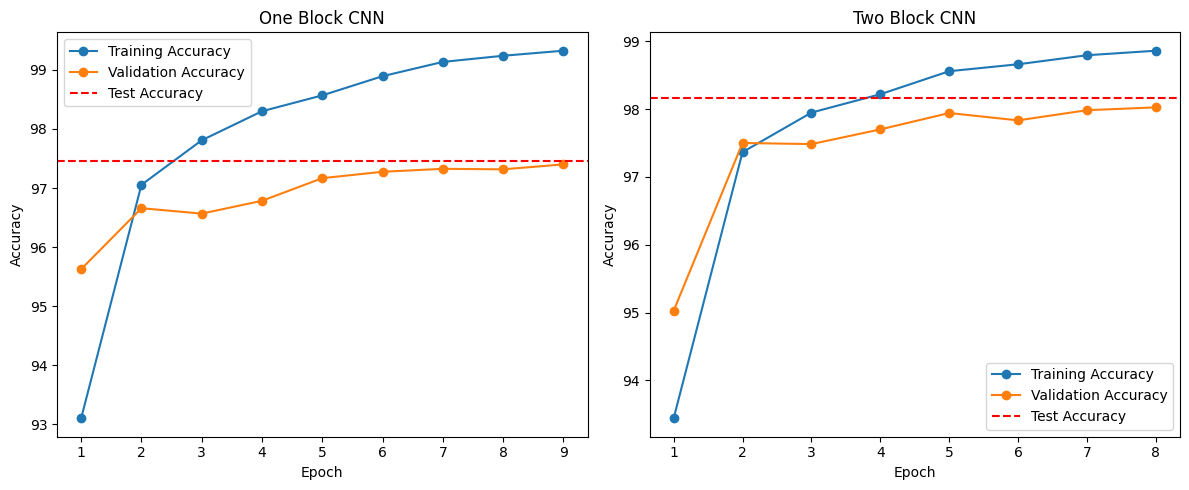

In [61]:
actual_num_epochs_one_block = len(train_accuracies_one_block)
epochs_one_block = list(range(1, actual_num_epochs_one_block + 1))

actual_num_epochs_two_block = len(train_accuracies_two_block)
epochs_two_block = list(range(1, actual_num_epochs_two_block + 1))

plt.figure(figsize=(12, 5))

# One-block model accuracies
plt.subplot(1, 2, 1)
plt.plot(epochs_one_block, train_accuracies_one_block, '-o', label='Training Accuracy')
plt.plot(epochs_one_block, val_accuracies_one_block, '-o', label='Validation Accuracy')
plt.axhline(y=test_accuracy_one_block, color='r', linestyle='--', label='Test Accuracy')
plt.title('One Block CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Two-block model accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_two_block, train_accuracies_two_block, '-o', label='Training Accuracy')
plt.plot(epochs_two_block, val_accuracies_two_block, '-o', label='Validation Accuracy')
plt.axhline(y=test_accuracy_two_block, color='r', linestyle='--', label='Test Accuracy')
plt.title('Two Block CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

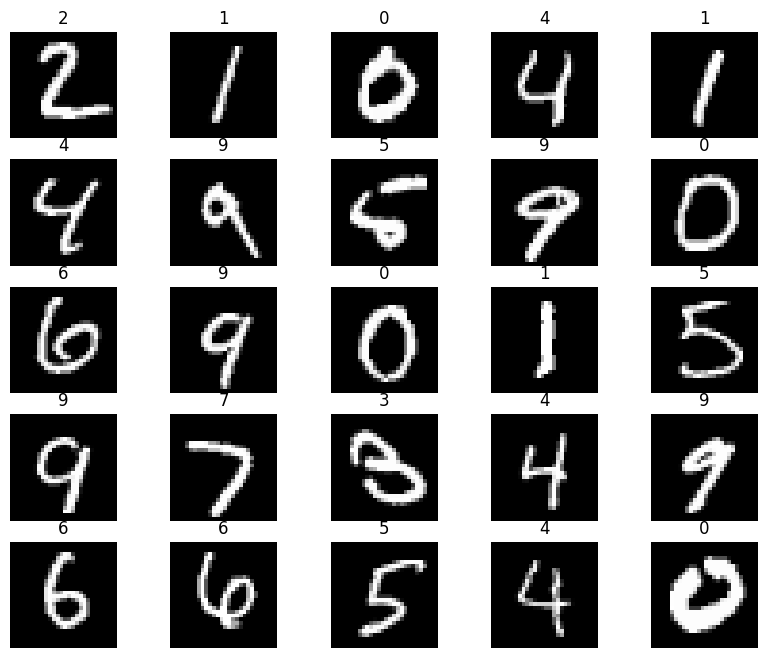

Prediction number: 	 [2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0]
Actual number: 	 	 [2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0]


In [62]:
imgs, lbls = next(iter(loaders['test']))
true_labels = lbls[:25].numpy()

# Using one_block_cnn for predictions
test_output = one_block_cnn(imgs[:25])
pred_labels = torch.max(test_output, 1)[1].data.numpy().squeeze()

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    img, pred_label = imgs[i-1,:,:,:], pred_labels[i-1].item()
    figure.add_subplot(rows, cols, i)
    plt.title(pred_label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

print(f'Prediction number: \t {pred_labels}')
print(f'Actual number: \t \t {true_labels}')

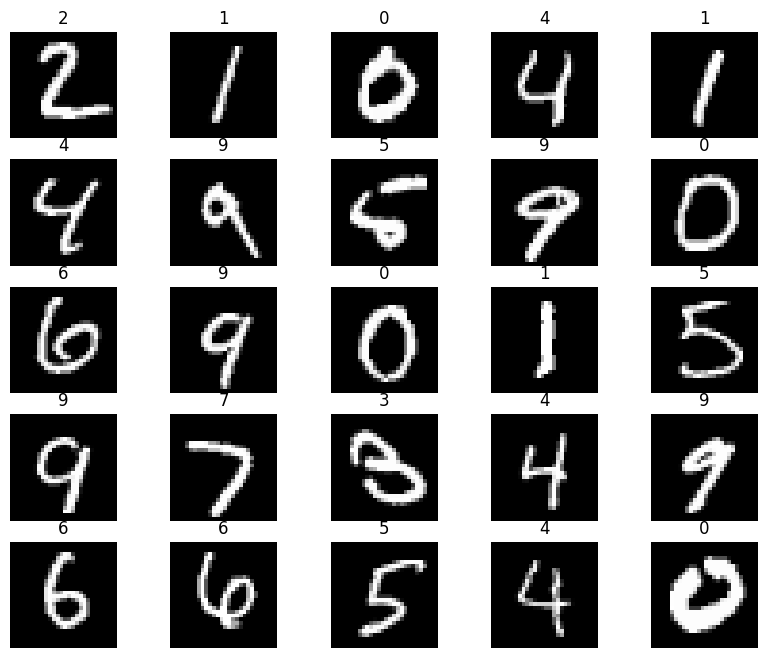

Prediction number: 	 [2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0]
Actual number: 	 	 [2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0]


In [63]:
imgs, lbls = next(iter(loaders['test']))
true_labels = lbls[:25].numpy()

# Using one_block_cnn for predictions
test_output = two_block_cnn(imgs[:25])
pred_labels = torch.max(test_output, 1)[1].data.numpy().squeeze()

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    img, pred_label = imgs[i-1,:,:,:], pred_labels[i-1].item()
    figure.add_subplot(rows, cols, i)
    plt.title(pred_label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

print(f'Prediction number: \t {pred_labels}')
print(f'Actual number: \t \t {true_labels}')